In [24]:
import os
import traceback
import numpy as np
from numpy import linalg as LA

from hyperbolicTSNE import Datasets
from hyperbolicTSNE import Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.cost_functions_ import HyperbolicKL
from hyperbolicTSNE.util import find_last_embedding, opt_config, initialize_logger, write_data, store_visuals
from hyperbolicTSNE.data_loaders import load_mnist
from hyperbolicTSNE.hd_mat_ import hd_matrix

# Dataset generation code
Generate a specific set of samples we want to use.
Right now we want 10 samples of data with labels 2 and 4.

In [25]:
# MNIST DATA 

# n_samples = 20             # How much to sample from each class
# dataX, dataLabels = load_mnist(data_home=data_home)
# print(dataX.shape, dataLabels.shape)

# indices_2 = np.where(dataLabels == 2)
# indices_4 = np.where(dataLabels == 4)

# samples_idx_2 = np.random.choice(indices_2[0], size=n_samples, replace=False)
# samples_idx_4 = np.random.choice(indices_4[0], size=n_samples, replace=False)

# print(samples_idx_2)
# print(samples_idx_4)

# print(dataLabels[samples_idx_2])
# print(dataLabels[samples_idx_4])

# labels_2 = dataLabels[samples_idx_2]
# labels_4 = dataLabels[samples_idx_4]
# sample_labels = np.concatenate((labels_2, labels_4), axis=0)

# samples_2 = dataX[samples_idx_2]        # samples of number 2
# samples_4 = dataX[samples_idx_4]        # samples of number 4
# sample_data = np.concatenate((samples_2, samples_4), axis=0)    # Contains both 2 and 4 

# print(sample_data.shape)    

In [26]:
from scipy.stats import multivariate_normal

def generate_linear_hierarchical_data(n_samples, n_clusters, n_dim, start, end):
    """ 
    Generate a "hierarchical" dataset where we basically generate clusters from "left" to "right" 
    """
    # n_samples must be a integer multiple of n_clusters
    points_per_cluster = n_samples
    cluster_distances = np.abs(end - start) / n_clusters                            # distance between each cluster
    cluster_centers = [start + i * cluster_distances for i in range(n_clusters)]    # centers of each cluster

    # Generate data
    data = []
    for center in cluster_centers:
        cluster_center = np.ones(n_dim) * center
        cluster_cov = np.identity(n_dim) * (cluster_distances / 3) ** 2
        #cluster_cov = np.identity(n_dim)
        cluster_data = multivariate_normal.rvs(mean=cluster_center, cov=cluster_cov, size=points_per_cluster)
        data.append(cluster_data)

    # Generate labels
    labels = []
    for i in range(n_clusters):
        labels = labels + [i for _ in range(points_per_cluster)]

    return np.array(data), np.array(labels)


# Custom data, Uniform distrib.
from scipy.stats import uniform 
def generate_uniform_clusters(n_samples, n_dim, b1, b2):
    # n_samples = 500
    # n_dim = 10
    # b1 = 1000000
    # b2 = 100

    # Bounds for first distribution
    lb_1 = np.ones(n_dim) * (-b1)
    ub_1 = np.ones(n_dim) * (-b2)
    widths_1 = ub_1 - lb_1 

    # Bounds for 2nd distribution
    lb_2 = np.ones(n_dim) * b2
    ub_2 = np.ones(n_dim) * b1
    widths_2 = ub_2 - lb_2

    # Draw samples 
    samples_1 = uniform.rvs(loc=lb_1, scale=widths_1, size=(n_samples, n_dim))
    samples_2 = uniform.rvs(loc=lb_2, scale=widths_2, size=(n_samples, n_dim))

    dataX = np.concatenate((samples_1, samples_2), axis=0)
    labels = [0 for _ in range(n_samples)] + [1 for _ in range(n_samples)]
    dataLabels = np.array(labels)

    return dataX, dataLabels

# Preperation for running embedding
Get the distance matrix and affinity matrix of our samples

In [27]:
n_samples = 5
n_clusters = 2
n_dim = 2
start = 0
end = 100

dataX, dataLabels = generate_linear_hierarchical_data(n_samples, n_clusters, n_dim, start, end)
dataX = dataX.reshape((dataX.shape[0] * dataX.shape[1], dataX.shape[2]))

In [28]:
hd_params = {"perplexity": n_samples}
D, V = hd_matrix(X=dataX, D=None, V=None,
                    knn_method="sklearn", metric="euclidean", n_neighbors=n_samples, knn_params=None,
                    hd_method="vdm2008", hd_params=hd_params, verbose=1)

Computing the kNN D matrix with k=9 nearest neighbors...
Using sklearn NearestNeighbor, an exact method, for the knn computation
Indexed 10 samples in 0.000s...
Computed neighbors for 10 samples in {duration:.3f}s...
`hd_method` set to `vdm2008`, running with perplexity 5. Returns (D, V)
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 42.994068


In [54]:
print(V.toarray())
    

[[0.         0.02430814 0.01938744 0.01234201 0.0262482  0.00049621
  0.00057218 0.00094344 0.00171821 0.00023953]
 [0.02430814 0.         0.02933131 0.02080494 0.0264169  0.00096
  0.00115507 0.00159318 0.00277431 0.000665  ]
 [0.01938744 0.02933131 0.         0.02444854 0.02474449 0.00146306
  0.00168624 0.00264336 0.00435312 0.00112184]
 [0.01234201 0.02080494 0.02444854 0.         0.02296029 0.00099817
  0.0007713  0.00451823 0.00288361 0.00126496]
 [0.0262482  0.0264169  0.02474449 0.02296029 0.         0.00058048
  0.0006118  0.00128927 0.00181968 0.00041977]
 [0.00049621 0.00096    0.00146306 0.00099817 0.00058048 0.
  0.02997299 0.02127155 0.02691969 0.02602463]
 [0.00057218 0.00115507 0.00168624 0.0007713  0.0006118  0.02997299
  0.         0.01227353 0.02367903 0.01917197]
 [0.00094344 0.00159318 0.00264336 0.00451823 0.00128927 0.02127155
  0.01227353 0.         0.02984043 0.02627383]
 [0.00171821 0.00277431 0.00435312 0.00288361 0.00181968 0.02691969
  0.02367903 0.02984043

Initialize configuration parameters and stuff

In [29]:
data_home = "datasets"
log_path = "temp/poincare/"  # path for saving embedding snapshots
grad_path = "temp/grad/"

seed = 42

dataset = Datasets.MNIST
num_points = [-1]
perplexities = [50]
correct_gradients = [True, False]                # NOTE: Recompile with correct flag (GRAD_FIX flag)
exact = True                                     # Exact computation or BH estimation of gradient
pca_components = 0                               # Whether to use pca initialization of high dim. data or not
grad_scale_fix = True                            # Whether we multiply the gradient by the inverse metric tensor of hyperbolic space or not
                                                 # Note that the correct hyperoblic gradient has an inverse metric tensor factor

# Simple experiment with no exaggeration
exaggeration_factor = 12
ex_iterations = 0
main_iterations = 1500
cf = HyperbolicKL

# Run embedding
Code below runs the embedding procedure for our specified dataset

In [30]:
for correct_gradient in correct_gradients:
    print(f"Experiment with grad_fix:{correct_gradient}")

    # Compute initial embedding in Poincare disk (PCA embedding)
    X_embedded = initialization(
        n_samples=dataX.shape[0], 
        n_components=2,
        X=dataX,
        random_state=seed,
        method="random"
    ) 

    # Initialize config and parameters
    learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)

    opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact=exact, grad_scale_fix=True, grad_fix=correct_gradient)
    opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 

    log_path_cf = log_path + f"correct_grad_{correct_gradient}/"
    grad_path_grad = grad_path + f"correct_grad_{correct_gradient}/"
    
    opt_params, opt_conf = initialize_logger(opt_params, opt_conf, log_path_cf, grad_path_grad)
    opt_params["cf_params"].update({"grad_fix" : correct_gradient})     # So the cost function knows which gradient to use
    
    # Set up H-TSNE object 
    htsne = HyperbolicTSNE(
        init=X_embedded, 
        n_components=2, 
        metric="precomputed", 
        verbose=1, 
        opt_method=SequentialOptimizer,         # the optimizater we use
        opt_params=opt_params              # the parameters for the optimizers
    )

    # Compute embedding:
    try:
        hyperbolicEmbedding = htsne.fit_transform((D, V))
        
    except ValueError:
        hyperbolicEmbedding = find_last_embedding(log_path)
        traceback.print_exc()

    # Store visuals
    # save_folder = "results/gradient_vis_images"
    # file_name = f"{save_folder}/gradienttesting_correctgrad:{correct_gradient}"
    # store_visuals(hyperbolicEmbedding, dataLabels, save_folder, file_name, opt_params)

Experiment with grad_fix:True
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'cf': <class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, 'learning_rate_ex': 0.0008333333333333334, 'learning_rate_main': 0.0008333333333333334, 'exaggeration': 12, 'exaggeration_its': 0, 'gradientDescent_its': 1500, 'vanilla': False, 'momentum_ex': 0.5, 'momentum': 0.8, 'exact': True, 'area_split': False, 'n_iter_check': 10, 'size_tol': 0.999, 'grad_scale_fix': True, 'grad_fix': True}
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent: 0it [00:00, ?it/s]


Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 0.01216 grad_norm: 2.78957e-04: 100%|██████████| 1500/1500 [00:06<00:00, 237.49it/s]


Experiment with grad_fix:False
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'cf': <class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, 'learning_rate_ex': 0.0008333333333333334, 'learning_rate_main': 0.0008333333333333334, 'exaggeration': 12, 'exaggeration_its': 0, 'gradientDescent_its': 1500, 'vanilla': False, 'momentum_ex': 0.5, 'momentum': 0.8, 'exact': True, 'area_split': False, 'n_iter_check': 10, 'size_tol': 0.999, 'grad_scale_fix': True, 'grad_fix': False}
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent: 0it [00:00, ?it/s]


Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 0.14808 grad_norm: 8.58205e-02: 100%|██████████| 1500/1500 [00:07<00:00, 202.05it/s]


# Gradient analysis notes:

- Upon preliminary observations, the true gradient tends to push embeddings towards the outer edge much more than the wrong gradient. 

- The correct gradient needs a bit of time before it starts moving the points outwards. The incorrect one starts moving faster.

- Possible explanation: 
$d^H_{ij}$ amplifies all the forces. The $F_{rep}$ force for points that are far away always contributes to the gradient because the t-distribution has heavy tails, so if points are already far away, they still have a considerable effect on eachother. 
[Analyze repulsive forces contribution?]

- Things to try to get a sense of the differences in gradients? Plot norms, plot difference in norms, ...


# Experiment (1)
Experiment to test the code and some preliminary data analysis of the gradients

C:\Users\Haoranxia\AppData\Local\Temp\ipykernel_19896\511416857.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


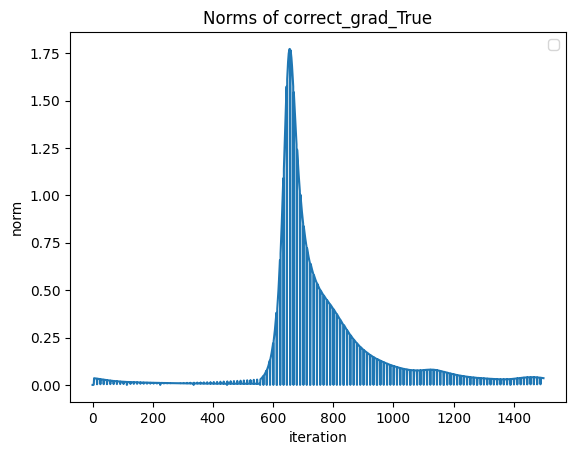

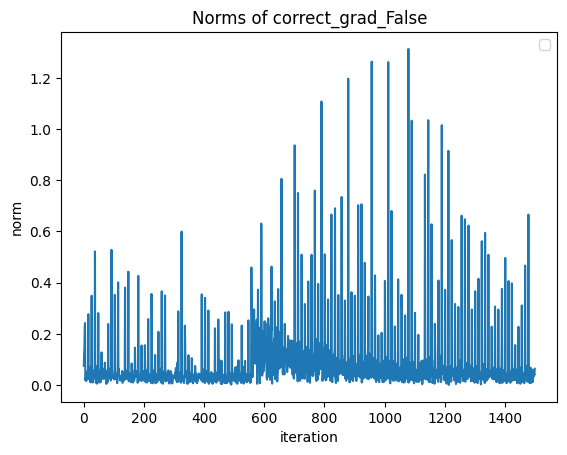

In [31]:
# Gradient analysis code. NOTE: Currently we only take into account the first entry (1 datapoint)
# Comparison of norm of gradients
import pandas as pd
import csv
from pathlib import Path 
import matplotlib.pyplot as plt

all_norms = []
# Read gradients from file
for correct_gradient in correct_gradients:
    folder_path = Path(f"temp/grad/correct_grad_{correct_gradient}")
    norms = []

    # After opening folder_path we encounter 2 more folders for the different optimizer results
    for optim_folder in folder_path.iterdir():

        # Open the folder and iterate over csvs
        for csv_file_path in optim_folder.iterdir():
            with csv_file_path.open('r') as file:
                reader = csv.reader(file)                               
                first_line = next(reader)
                grad = np.array([float(val) for val in first_line])     # convert read strings to float
                norms.append(LA.norm(grad))                             # compute norm and store value

    # Plot the norms
    norms = np.array(norms)
    idxs = np.array([i for i in range(norms.shape[0])])
    all_norms.append(norms)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the data
    ax.plot(idxs, norms)

    # Add labels and title
    ax.set_xlabel('iteration')
    ax.set_ylabel('norm')
    ax.set_title(f'Norms of correct_grad_{correct_gradient}')
    ax.legend()

    # Show the plot
    plt.show()

C:\Users\Haoranxia\AppData\Local\Temp\ipykernel_19896\2895653599.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


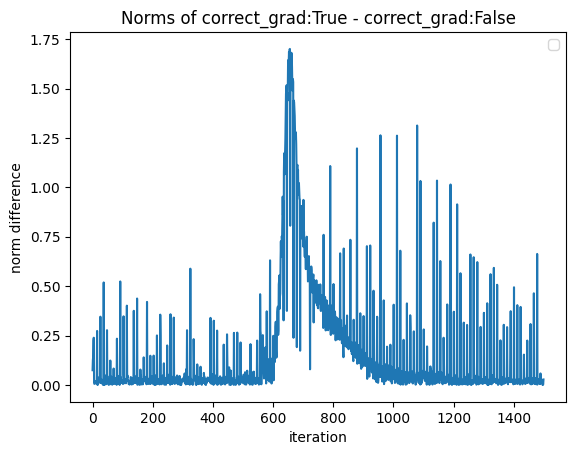

In [32]:
# Norm difference of [correct gradients] - [incorrect gradients]
norm_difference = np.abs(all_norms[0] - all_norms[1])
idxs = np.array([i for i in range(norm_difference.shape[0])])

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(idxs, norm_difference)

# Add labels and title
ax.set_xlabel('iteration')
ax.set_ylabel('norm difference')
ax.set_title(f'Norms of correct_grad:{True} - correct_grad:{False}')
ax.legend()

# Show the plot
plt.show()

# Experiment (2)
Compute both gradients for the same embeddings. Choice of embedding should be set manually

In [33]:
from gradient_experiments import GradientComparisons
from pathlib import Path

embedding_folder_path = "temp/poincare/correct_grad_True"              # Where our embeddings are 
output_folder_path = "results/gradient_comparisons"                    # Where to store our results
V = V                                                                   # High dim. affinity matrix, precomputed

# For each type of gradient, calculate the gradients and stor # the results
for correct_gradient in correct_gradients:
    # Initialize config and parameters
    learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)

    opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact=exact, grad_scale_fix=True, grad_fix=correct_gradient)
    opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 
    opt_params["cf_params"].update({"grad_fix" : correct_gradient})         # So the cost function knows which gradient to use
    params = opt_params["cf_config_params"] | opt_params["cf_params"]       # Params to initialize cf

    key = f"linear_hierarchical_data_nclusters_{n_clusters}_ndata_{n_samples}"
    cf = HyperbolicKL(n_components=2, other_params=params)                  
    
    # Run experiment
    Experiment_Gradients = GradientComparisons(embedding_folder_path, cf, key)  
    Experiment_Gradients.compute_gradients(V, correct_gradient, output_folder_path)

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.


Now that we have all the gradients of the 2 versions, what can we do?
- Take some specific instances of embeddings. For example, when everything is randomly initialized at the oriign
- Compute gradients for each version. Manually look at differnces and try to hypothesize something
- Repeat this for a few scenarios. For example, when clusters have formed. When mixed, etc...

In [43]:
# Lets examine gradients of step 0
gradients_directory = Path("results/gradient_comparisons")

# The iteration we want to analyze
emb_it = 700                                     

# Load gradients corresponding to "emb_it"
data = dict()
for idx, gradient_folder in enumerate(gradients_directory.iterdir()):       # Only 2 directories (Correct & Incorrect gradient)
    # Load gradient data from the iteration we want
    gradient_file_path = Path(f"{gradient_folder}/it_{emb_it}.csv")
    gradient_data = np.loadtxt(str(gradient_file_path), delimiter=',')
    key = "Wrong_Grad" if (idx == 0) else "Correct_Grad"
    data[key] = gradient_data



# Load embedding corresponding to "emb_it"
embeddings_directory = Path("temp/poincare/correct_grad_True/solver_gradient_descent_sequential_opt_1")
emb_file_path = Path(f"{embeddings_directory}/{emb_it}.csv")
emb_data = np.loadtxt(str(emb_file_path), delimiter=',')
data["Emb"] = emb_data

In [44]:
# for key in data:
#     print(key)
#     print(data[key])
#     print()

print(data["Emb"].shape)
print(data["Emb"][:, 0])
print(data["Emb"][0])
# Note that the indices of dataLabels correspond to indices of data["Emb"]
print(dataLabels)

(10, 2)
[ 0.53663452  0.48083263  0.44397574  0.38041317  0.49262057 -0.48857542
 -0.49998564 -0.44283841 -0.40031285 -0.5569391 ]
[0.53663452 0.63805927]
[0 0 0 0 0 1 1 1 1 1]


So what do we do now with the data?

**data** contains computed gradients for each version, and the corresponding embedding 
- Embeddings are really close to eachother
- Zoom in, plot the points, and visualize the gradient vectors for each point?
- Compute angle differences between gradients? What parameters may be influencing this?

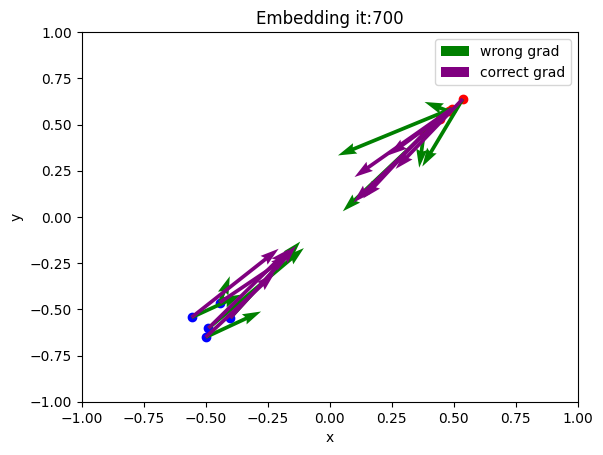

In [67]:
scaling_factor = 1
grad_scaling_factor = 3000
wrong_grad_scaling_factor = 1

# Plot embedding points
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
scaled_data = data["Emb"] * scaling_factor

# In our current situation we have 2 clusters with n_samples elements each
ax.scatter(scaled_data[:n_samples, 0], scaled_data[:n_samples, 1], color='red')
ax.scatter(scaled_data[n_samples:, 0], scaled_data[n_samples:, 1], color='blue')

# Plot the gradients 
scaled_wrong_grad = data["Wrong_Grad"] * wrong_grad_scaling_factor
ax.quiver(scaled_data[:, 0], scaled_data[:, 1], scaled_wrong_grad[:, 0], scaled_wrong_grad[:, 1],
          angles='xy', scale_units='xy', scale=1, color='green', label="wrong grad")

scaled_correct_grad = data["Correct_Grad"] * grad_scaling_factor
ax.quiver(scaled_data[:, 0], scaled_data[:, 1], scaled_correct_grad[:, 0], scaled_correct_grad[:, 1],
          angles='xy', scale_units='xy', scale=1, color='purple', label="correct grad")

# Set axis limits
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Add labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Embedding it:{emb_it}')

ax.legend()

# Show the plot
plt.show()

In [80]:
def compute_emb_probabilities(emb_data):
    Q = np.zeros((emb_data.shape[0], emb_data.shape[0]))

    # Note that Q is a symmetric matrix, so we only need to compute a diagonal half
    for i in range(0, Q.shape[0]):
        for j in range(i + 1, Q.shape[0]):
            # Compute embedding probability between (i, j)
            
            num = np.linalg.norm(emb_data[i] - emb_data[j])
            denum = (1 - np.linalg.norm(emb_data[i])) * (1 - np.linalg.norm(emb_data[j]))
            dist = np.arccosh(1 + 2 * (num / denum))
            t_distrib_dist = 1. / (1 + dist**2)
            Q[i][j] = t_distrib_dist
            Q[j][i] = t_distrib_dist
    
    return Q / Q.sum()


# Recomputing probability matrices
P_ij = V.toarray() 
Q_ij = compute_emb_probabilities(data["Emb"])

print(P_ij)
print()
print(Q_ij)

print(P_ij - Q_ij)

[[0.         0.02430814 0.01938744 0.01234201 0.0262482  0.00049621
  0.00057218 0.00094344 0.00171821 0.00023953]
 [0.02430814 0.         0.02933131 0.02080494 0.0264169  0.00096
  0.00115507 0.00159318 0.00277431 0.000665  ]
 [0.01938744 0.02933131 0.         0.02444854 0.02474449 0.00146306
  0.00168624 0.00264336 0.00435312 0.00112184]
 [0.01234201 0.02080494 0.02444854 0.         0.02296029 0.00099817
  0.0007713  0.00451823 0.00288361 0.00126496]
 [0.0262482  0.0264169  0.02474449 0.02296029 0.         0.00058048
  0.0006118  0.00128927 0.00181968 0.00041977]
 [0.00049621 0.00096    0.00146306 0.00099817 0.00058048 0.
  0.02997299 0.02127155 0.02691969 0.02602463]
 [0.00057218 0.00115507 0.00168624 0.0007713  0.0006118  0.02997299
  0.         0.01227353 0.02367903 0.01917197]
 [0.00094344 0.00159318 0.00264336 0.00451823 0.00128927 0.02127155
  0.01227353 0.         0.02984043 0.02627383]
 [0.00171821 0.00277431 0.00435312 0.00288361 0.00181968 0.02691969
  0.02367903 0.02984043

In [63]:
# Print gradients of iteration emb_it
print("iteration: ", emb_it)
print()

# correct gradients
print("Correct Grads")
print(data["Correct_Grad"])
print()

# wrong gradients
print("Wrong Grads")
print(data["Wrong_Grad"])

iteration:  700

Correct Grads
[[-9.02392707e-05 -1.26140096e-04]
 [-8.09321161e-05 -7.89687769e-05]
 [-1.16024456e-04 -1.49827100e-04]
 [-8.16995692e-05 -1.17611033e-04]
 [-1.30776497e-04 -1.23373237e-04]
 [ 1.07967740e-04  1.42245464e-04]
 [ 9.24470406e-05  1.15134937e-04]
 [ 9.39149217e-05  8.47990068e-05]
 [ 8.82493677e-05  1.29876383e-04]
 [ 1.17092839e-04  1.23864457e-04]]

Wrong Grads
[[-0.16295333 -0.36519383]
 [-0.09825818  0.05062991]
 [-0.39091975 -0.49706612]
 [-0.01946143 -0.18683429]
 [-0.45917305 -0.25319881]
 [ 0.38466228  0.43356611]
 [ 0.22361823  0.13931548]
 [ 0.04022834  0.14253552]
 [ 0.28181083  0.41287801]
 [ 0.20044605  0.12336803]]


# Preliminary analysis

It seems that the correct gradient has much higher magnitudes than the wrong gradients